# Using Machine Learning to determine photometric redshift

## Lecture given by Miguel Angel Aragon, del Instituto de Astronomia de la UNAM, sede de Ensenada.


## This Notebook can be run in Google Colab, where all the needed libbraries are already installed.
## You can use the CPU or GPU configuration, it almost takes the same time to run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense


## Download the data from the github repository

In [2]:
#- redshift, photo-z, m_u, m_g, m_r, m_i, m_z, petro50, petro90
try:
  sdss = np.load('DR9_photo-z-small.npy')
except:
  ! wget https://github.com/Morisset/Python-lectures-Notebooks/raw/master/Notebooks/DR9_photo-z-small.npy
  sdss = np.load('DR9_photo-z-small.npy')

--2021-01-22 21:27:16--  https://github.com/Morisset/Python-lectures-Notebooks/raw/master/Notebooks/DR9_photo-z-small.npy
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Morisset/Python-lectures-Notebooks/master/Notebooks/DR9_photo-z-small.npy [following]
--2021-01-22 21:27:17--  https://raw.githubusercontent.com/Morisset/Python-lectures-Notebooks/master/Notebooks/DR9_photo-z-small.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3600128 (3.4M) [application/octet-stream]
Saving to: ‘DR9_photo-z-small.npy’

DR9_photo-z-small.n 100%[===================>]   3.43M  --.-KB/s    in 0.1s    

2021-01

In [3]:
# Shape of the data
sdss.shape

(100000, 9)

In [4]:
sdss[0]

array([ 0.39964026,  0.344148  , 25.683548  , 20.814222  , 19.111876  ,
       18.458895  , 18.351385  ,  2.3227189 ,  5.778584  ], dtype=float32)

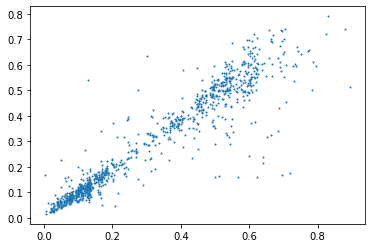

In [5]:
plt.scatter(sdss[0:1000,0], sdss[0:1000, 1], s=1);

## Put the data in a pandas DataFrame

In [18]:
sdss_df = pd.DataFrame(sdss, columns=('redshift', 'photo-z', 'm_u', 'm_g', 'm_r', 'm_i', 'm_z', 'petro50', 'petro90'))
# Adding log, more efficient to determine redshift
sdss_df['log_petro50'] = np.log10(sdss_df['petro50'])
sdss_df['log_petro90'] = np.log10(sdss_df['petro90'])

# Selection of the used columns
X_columns = ['m_u', 
             'm_g', 
             'm_r', 
             'm_i', 
             'm_z', 
#             'petro50', 
             'log_petro90']
             
y_columns = ['redshift']

## Split the data set into training and testing

In [12]:
train = sdss_df.sample(frac=0.9, random_state=32) #random state is a seed value
test = sdss_df.drop(train.index)

X_train = train[X_columns]
y_train = train[y_columns]

X_test = test[X_columns]
y_test = test[y_columns]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

n_X = X_train.shape[1]

(90000, 6) (90000, 1) (10000, 6) (10000, 1)


## Compare the redshift and the photo-z columns:

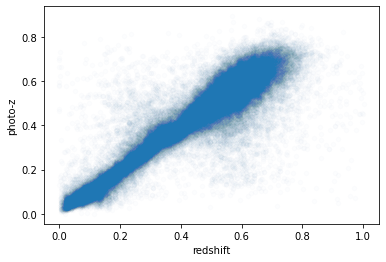

In [7]:
sdss_df.plot.scatter('redshift', 'photo-z', alpha=0.01);

## Build the Artificial Neuron Network

In [8]:
model = Sequential()

model.add(Dense(8, input_dim=n_X, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


## Train the Neuron Network

In [9]:
model.fit(X_train, y_train, epochs=20, batch_size=10, verbose=1)

Epoch 1/20
9000/9000 [==============================] - 15s 1ms/step - loss: 37.0233 - mse: 37.0233
Epoch 2/20
9000/9000 [==============================] - 13s 1ms/step - loss: 0.0091 - mse: 0.0091
Epoch 3/20
9000/9000 [==============================] - 13s 1ms/step - loss: 0.0066 - mse: 0.0066
Epoch 4/20
9000/9000 [==============================] - 13s 1ms/step - loss: 0.0063 - mse: 0.0063
Epoch 5/20
9000/9000 [==============================] - 13s 1ms/step - loss: 0.0060 - mse: 0.0060
Epoch 6/20
9000/9000 [==============================] - 13s 1ms/step - loss: 0.0060 - mse: 0.0060
Epoch 7/20
9000/9000 [==============================] - 13s 1ms/step - loss: 0.0057 - mse: 0.0057
Epoch 8/20
9000/9000 [==============================] - 13s 1ms/step - loss: 0.0056 - mse: 0.0056
Epoch 9/20
9000/9000 [==============================] - 13s 1ms/step - loss: 0.0055 - mse: 0.0055
Epoch 10/20
9000/9000 [==============================] - 13s 1ms/step - loss: 0.0055 - mse: 0.0055
Epoch 11/20
9000/

## Predict the redshift for the test set

In [10]:
y_pred = model.predict(X_test)

## Compare predictions with "real" values from the test set

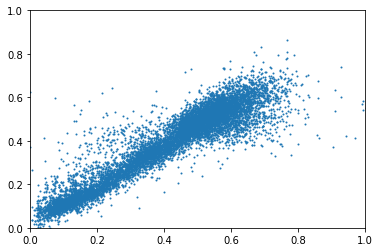

In [17]:
f, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=1)
ax.set_xlim(0,1)
ax.set_ylim(0,1);

## Standart deviation of the difference between prediction and real values

In [15]:
print(np.std(y_test - y_pred))

redshift    0.071576
dtype: float32
